In [1]:
%matplotlib inline

import pandas as pd
import geopandas
import json
from shapely.geometry import Point

In [2]:
geojson = {
        'type': 'FeatureCollection',
        'features': []
      }
zones = []

with open('ref_data/idf.json', 'r') as file_i:
    tt = json.load(file_i)
    zones = tt['zones']

    
geojson['features'] = [{
'type': 'Feature',
'geometry': a_zone['geometry'],
'properties': {key: value for key, value in a_zone.items() if key != 'geometry'}
} for a_zone in zones]

with open('cosmogony.geojson', 'w') as file_o:
    json.dump(geojson, file_o)
    
zones = geopandas.read_file('cosmogony.geojson', driver='GeoJSON')
zones.head()

,osm_id,wikidata,center,name,zone_type,admin_level,id,parent,geometry
0,7383,Q12753,"{'y': 48.539927, 'x': 2.660817}",Seine-et-Marne,state_district,6,0,8,"(POLYGON ((3.0294998 48.2855332, 3.029456 48.2..."
1,7389,Q12761,"{'y': 48.906387, 'x': 2.445223}",Seine-Saint-Denis,state_district,6,1,8,"(POLYGON ((2.5535179 49.0101078, 2.5531876 49...."
2,7401,Q3368,"{'y': 48.6311, 'x': 2.438}",Essonne,state_district,6,2,8,"(POLYGON ((2.233067 48.766197, 2.233127 48.766..."
3,7433,Q12784,"{'y': 49.052753, 'x': 2.038874}",Val-d'Oise,state_district,6,3,8,"(POLYGON ((2.0236394 48.9979223, 2.023665 48.9..."
4,7444,Q90,"{'y': 48.85661, 'x': 2.351499}",Paris,city,8,4,126,"(POLYGON ((2.3198895 48.90045869999999, 2.3187..."


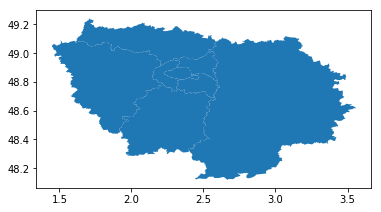

In [10]:
dept = zones[zones['admin_level']==6]
#TODO : extraire juste les polygones des departements et benner le fichier cosmogony
dept.plot()

In [4]:
osm_routepoints = pd.read_csv("../data/osm_routepoints.csv", dtype=str)
for c in osm_routepoints.columns:
    new_col = "osm_" + c
    osm_routepoints.rename(columns={c: new_col}, inplace=True)

gtfs_routepoints = pd.read_csv("../data/gtfs_routepoints.csv", dtype=str)
for c in gtfs_routepoints.columns:
    new_col = "gtfs_" + c
    gtfs_routepoints.rename(columns={c: new_col}, inplace=True)
    
gtfs_routepoints.head()

,gtfs_stop_id,gtfs_route_id,gtfs_ZDEr_ID_REF_A,gtfs_stop_name,gtfs_stop_lat,gtfs_stop_lon,gtfs_wheelchair_boarding,gtfs_dest_name,gtfs_route_short_name,gtfs_agency_name
0,StopPoint:4:110,002002002:BDE,10296,Général de Gaulle,48.73564,2.424307,NaN,Hotels,BDE,Keolis Seine Val-De-Marne
1,StopPoint:4:111,002002002:BDE,423888,Général de Gaulle,48.735631,2.42413,NaN,Hotels,BDE,Keolis Seine Val-De-Marne
2,StopPoint:4:112,002002002:BDE,2708,Ecoles,48.73257,2.442115,NaN,Hotels,BDE,Keolis Seine Val-De-Marne
3,StopPoint:4:113,002002002:BDE,21636,Ecoles,48.732705,2.441857,NaN,Hotels,BDE,Keolis Seine Val-De-Marne
4,StopPoint:4:114,002002002:BDE,21637,EDF,48.729472,2.438712,NaN,Hotels,BDE,Keolis Seine Val-De-Marne


In [14]:
def lat_lon_to_geom(row):
    return Point(float(row['gtfs_stop_lon']),float(row['gtfs_stop_lat']))

gtfs_routepoints['geometry'] = gtfs_routepoints.apply(lat_lon_to_geom, axis=1)
gtfs_routepoints


,gtfs_stop_id,gtfs_route_id,gtfs_ZDEr_ID_REF_A,gtfs_stop_name,gtfs_stop_lat,gtfs_stop_lon,gtfs_wheelchair_boarding,gtfs_dest_name,gtfs_route_short_name,gtfs_agency_name,geometry
0,StopPoint:4:110,002002002:BDE,10296,Général de Gaulle,48.73564,2.424307,0,Hotels,BDE,Keolis Seine Val-De-Marne,POINT (2.424307 48.73564)
1,StopPoint:4:111,002002002:BDE,423888,Général de Gaulle,48.735631,2.42413,0,Hotels,BDE,Keolis Seine Val-De-Marne,POINT (2.42413 48.735631)
2,StopPoint:4:112,002002002:BDE,2708,Ecoles,48.73257,2.442115,0,Hotels,BDE,Keolis Seine Val-De-Marne,POINT (2.442115 48.73257)
3,StopPoint:4:113,002002002:BDE,21636,Ecoles,48.732705,2.441857,0,Hotels,BDE,Keolis Seine Val-De-Marne,POINT (2.441857 48.732705)
4,StopPoint:4:114,002002002:BDE,21637,EDF,48.729472,2.438712,0,Hotels,BDE,Keolis Seine Val-De-Marne,POINT (2.438712 48.729472)
5,StopPoint:4:115,002002002:BDE,2709,EDF,48.729516,2.439011,0,Hotels,BDE,Keolis Seine Val-De-Marne,POINT (2.439011 48.729516)
6,StopPoint:4:121,002002002:BDE,21642,Villeneuve-le-roi Gare RER,48.739757,2.423688,0,Hotels,BDE,Keolis Seine Val-De-Marne,POINT (2.423688 48.739757)
7,StopPoint:4:122,002002002:BDE,2714,Villeneuve-le-roi Gare RER,48.740133,2.42657,0,Hotels,BDE,Keolis Seine Val-De-Marne,POINT (2.42657 48.740133)
8,StopPoint:4:122,002002002:BDE,2714,Villeneuve-le-roi Gare RER,48.740133,2.42657,0,Hotels,BDE,Keolis Seine Val-De-Marne,POINT (2.42657 48.740133)
9,StopPoint:4:123,002002002:BDE,423887,Villeneuve-le-roi Gare RER,48.739731,2.423457,0,Hotels,BDE,Keolis Seine Val-De-Marne,POINT (2.423457 48.739731)


In [17]:
gtfs_routepoints.reset_index()
gtfs_routepoints.plot()

TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
#zones[zones.contains(notre_dame)].sort_values(by=['admin_level'], ascending=False)